
Name: Rahmani Dibansa

Date: 25th of August 2022

Description:
    This contains my output for the homework on lecture 8

Reference(s):
    ACMSIGGRAPH. SIGGRAPH Now | Hands-on Workshop: Machine Learning and Neural Networks – Lecture 8

    Retrieved from: https://www.youtube.com/watch?v=MC9mLYrTCsM&list=PLUPhVMQuDB_b2kcOooEduedthcBH53mvC&index=7


Additional Comments:
- Basically, the generative adversial network uses a training dataset so that it can learn to generate an image that looks similar to the inputs. If used in an image dataset, it will generate an image that looks authentic. As such, this can be used to artificially generate new faces

- To make this possible, the GAN has two main components. One is the generator, this is responsible for generating noise that will eventually look authentic enough. The second part is a classifier/discriminator that checks whether the generated noise looks authentic.

In [1]:
# To generate GIFs
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import the necessary packages
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
!pip freeze > requirements.txt

In [6]:
# Load the apple and o range dataset from provided by tensorflow
dataset, metadata = tfds.load('cycle_gan/apple2orange', with_info=True, as_supervised=True)

# Take the datasets of apples
train_apples, train_oranges = dataset['trainA'], dataset['trainB']
test_apples, test_oranges = dataset['testA'], dataset['testB']

# Set the parameters
#BUFFER_SIZE = 1000
#BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Display the training data of apples
print(train_apples)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [7]:
# Display the metadata of the dataset
print(metadata)

tfds.core.DatasetInfo(
    name='cycle_gan',
    full_name='cycle_gan/apple2orange/2.0.0',
    description="""
    A dataset consisting of images from two classes A and B (For example: horses/zebras, apple/orange,...)
    """,
    homepage='https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/',
    data_path='~/tensorflow_datasets/cycle_gan/apple2orange/2.0.0',
    file_format=tfrecord,
    download_size=74.82 MiB,
    dataset_size=76.89 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'testA': <SplitInfo num_examples=266, num_shards=1>,
        'testB': <SplitInfo num_examples=248, num_shards=1>,
        'trainA': <SplitInfo num_examples=995, num_shards=1>,
        'trainB': <SplitInfo num_examples=1019, num_shards=1>,
    },
    citation="""@article{DBLP:journ

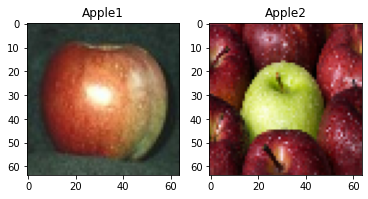

In [8]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32
train_horses = dataset['trainA']

# Normalize the image by
# resizing it down to 64*64
def normalize_img(image, label):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  image = tf.image.resize(image, [64, 64])
  return image

# Apply the normalize image function to the training dataset
train_horses = train_horses.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

# Display some of the apple images
sample_horse = next(iter(train_horses))
plt.subplot(121)
plt.title('Apple1')
plt.imshow(sample_horse[0] * 0.5 + 0.5)
sample_horse = next(iter(train_horses))
plt.subplot(122)
plt.title('Apple2')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

In [11]:
# This is the model for the generator part of the GAN
def make_generator_model():
    # Make a input layer for noise
    # normalize it and apply leakyReLU
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape the noise
    model.add(layers.Reshape((16, 16, 256)))
    assert model.output_shape == (None, 16, 16, 256) # Note: None is the batch size

    # Use deconvolution to up sample the noise that we have
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Again, up sample and turn the output shape into 32*32
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # up sample to make it 64*64
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # up sample to 128*128
    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    #model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 16)
    #assert model.output_shape == (None, 128, 128, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # up sample to get the result which is a 64 * 64 colored image
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

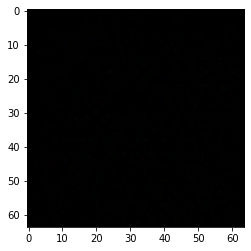

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
#noise = tf.random.uniform([1, 100], 0, 1)
#print('noise', noise)
# sanity check
generated_image = generator(noise, training=False)
#print('generated', generated_image)
plt.imshow(tf.squeeze(generated_image, axis=0)) #, cmap='gray')

In [13]:
# discriminator is just a simple classifier
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [14]:
# sanity check
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00175047]], shape=(1, 1), dtype=float32)


In [15]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [19]:
# save checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [22]:
EPOCHS = 20
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [21]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [23]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [24]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model

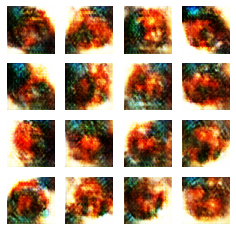

In [25]:
train(train_horses, EPOCHS)


# Additional comment:
#       - After 20 epoch, it does have some semblance to an apple.
#         However, I like the output from the previous epoch (19).
#         Maybe, it was because it had an output that has a more
#         prominent color of red

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [26]:
import glob
from PIL import Image

# filepaths
fp_in = "image_at_epoch*.png"
fp_out = "image.gif"
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)